## Projeto: CLASSIFICAÇÃO DE ANIMAIS USANDO MACHINE LEARNING(TENSORFLOW)

#### PAULO HENRIQUE DE FRANÇA ARAUJO CUNHA - 117277009

#### COCADA - 2023.2

------------------------------------------------------------------------

Importando Bibliotecas

In [1]:
# TensorFlow e tf.keras
import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


# Bibliotecas Auxiliares
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL

print(tf.__version__)

2.15.0


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!pip install kaggle; #caso seja necessário atualizar a biblioteca no google colab

kaggle_creds_path = "/content/drive/MyDrive/projeto-cocada/kaggle.json"

#antes de importar o dataset nós iremos provisionar o local de armazenamento
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/projeto-cocada/kaggle.json" ~/.kaggle/
#Alterar a permissão para evitar o aviso durante a partida da ferramenta Kaggle
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

#Aceitar a competição e copiar o endereço da API para o download do dataset
!kaggle datasets download -d iamsouravbanerjee/animal-image-dataset-90-different-animals


# Define o diretório de destino
destino_descompactacao = "/content/drive/MyDrive/projeto-cocada/dataset"

# Cria o diretório se não existir
!mkdir -p $destino_descompactacao

# Move para o diretório de destino
%cd $destino_descompactacao

#Descompactar o arquivo baixado
!unzip \*.zip  && rm *.zip



A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: animals/animals/bison/74dc1dd32a.jpg  
  inflating: animals/animals/bison/75ab166a7d.jpg  
  inflating: animals/animals/bison/79e1610d01.jpg  
  inflating: animals/animals/bison/7ba5eee91f.jpg  
  inflating: animals/animals/bison/7d214aab4b.jpg  
  inflating: animals/animals/bison/7f2ef9ab03.jpg  
  inflating: animals/animals/bison/82ec723a4f.jpg  
  inflating: animals/animals/bison/85e145af6c.jpg  
  inflating: animals/animals/bison/862e2c6379.jpg  
  inflating: animals/animals/bison/87a5c700ad.jpg  
  inflating: animals/animals/bison/88b723ce90.jpg  
  inflating: animals/animals/bison/8c3af742c3.jpg  
  inflating: animals/animals/bison/8e34044b98.jpg  
  inflating: animals/animals/bison/8e6adbdc40.jpg  
  inflating: animals/animals/bison/8fce80d5ba.jpg  
  inflating: animals/animals/bison/961a895686.jpg  
  inflating: animals/animals/bison/984a5b583d.jpg  
  inflating: animals/animals/bison/9e150d02f9.jpg  
  inf

Definindo e importando a pasta contendo o dataset

In [4]:
import pathlib
data_dir="/content/drive/MyDrive/projeto-cocada/dataset/animals/animals"
data_dir = pathlib.Path(data_dir)


Lendo o Dataset e verificando quantas imagens estão nele

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

5400


Pegando uma foto do dataset e mostrando como exemplo

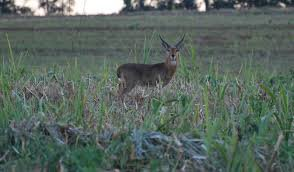

In [7]:
antelope = list(data_dir.glob('antelope/*'))
PIL.Image.open(str(antelope[0]))

Definindo variáveis iniciais para treinamento do modelo

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Gerando "corte" do dataset para treinamento e validação

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5400 files belonging to 90 classes.
Using 4320 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5403 files belonging to 90 classes.
Using 1080 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


Testando o dataset dividido e pegando imagens dele

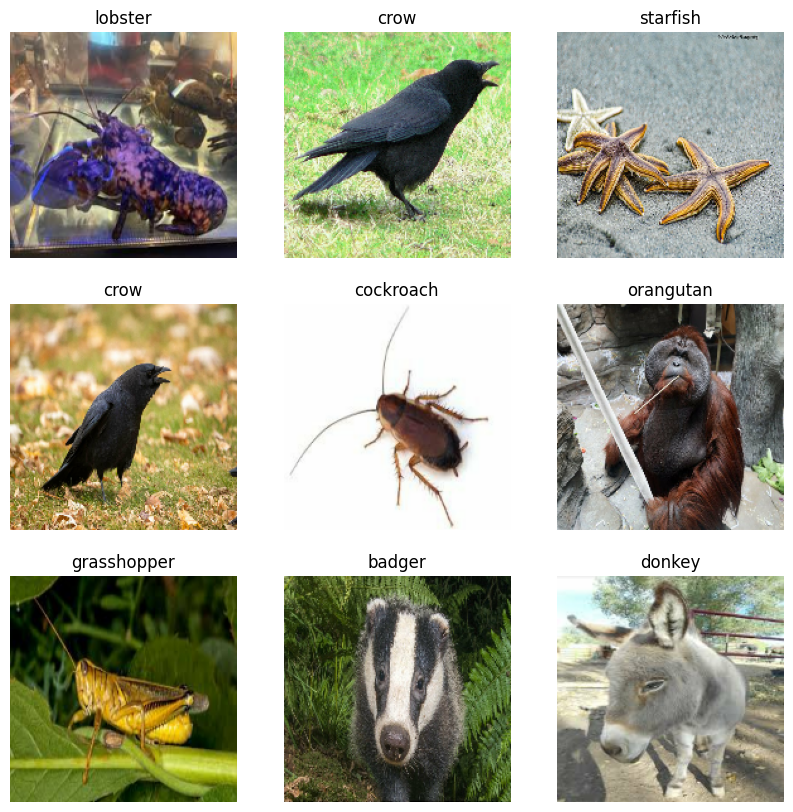

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Colocando imagens em cache, para diminuir o tempo de "leitura no disco"

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Primeiro Teste

Criando primeiro modelo inicial para aprendizado:

In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compilando modelo:

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Gerando um resumo do modelo compilado:

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

Treinando o modelo:

In [17]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
135/135 [==============================] - 33s 68ms/step - loss: 4.4764 - accuracy: 0.0211 - val_loss: 4.4027 - val_accuracy: 0.0278
Epoch 2/10
135/135 [==============================] - 3s 20ms/step - loss: 4.1586 - accuracy: 0.0674 - val_loss: 3.9260 - val_accuracy: 0.1111
Epoch 3/10
135/135 [==============================] - 3s 20ms/step - loss: 3.3075 - accuracy: 0.2299 - val_loss: 3.4385 - val_accuracy: 0.2472
Epoch 4/10
135/135 [==============================] - 3s 20ms/step - loss: 1.9577 - accuracy: 0.5215 - val_loss: 3.1452 - val_accuracy: 0.3907
Epoch 5/10
135/135 [==============================] - 3s 21ms/step - loss: 0.8233 - accuracy: 0.7949 - val_loss: 3.9532 - val_accuracy: 0.4574
Epoch 6/10
135/135 [==============================] - 3s 20ms/step - loss: 0.2669 - accuracy: 0.9324 - val_loss: 4.5249 - val_accuracy: 0.4815
Epoch 7/10
135/135 [==============================] - 3s 20ms/step - loss: 0.0954 - accuracy: 0.9729 - val_loss: 5.4357 - val_accuracy: 0.474

Gerando gráficos para saber eficácia do modelo:

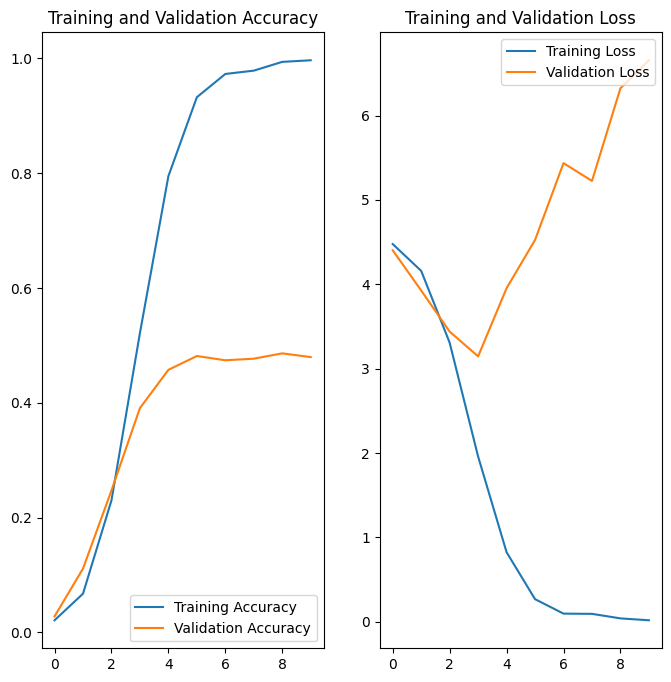

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Resultado Teste 1:


Ao conferir os resultamos do primeiro teste, temos que a acuracia dos dados de validação ficou muito abaixo do de treinamento.
Dessa forma obtivemos um overfit nesse modelo treinado, os dados de treino tiveram um desempenho muito bom, enquanto os de validação tiveram um desempenho muito abaixo.
Dessa forma, é necessário pensar em formas de diluir esse problema.

Antes de começar o proximo teste, tentarei utilizar algumas tecnicas para diminuir o problema de overfitting:

Primeira: Criação de mais imagens derivadas do dataset

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Plotando alguns resultados aplicados utilizando a função acima:

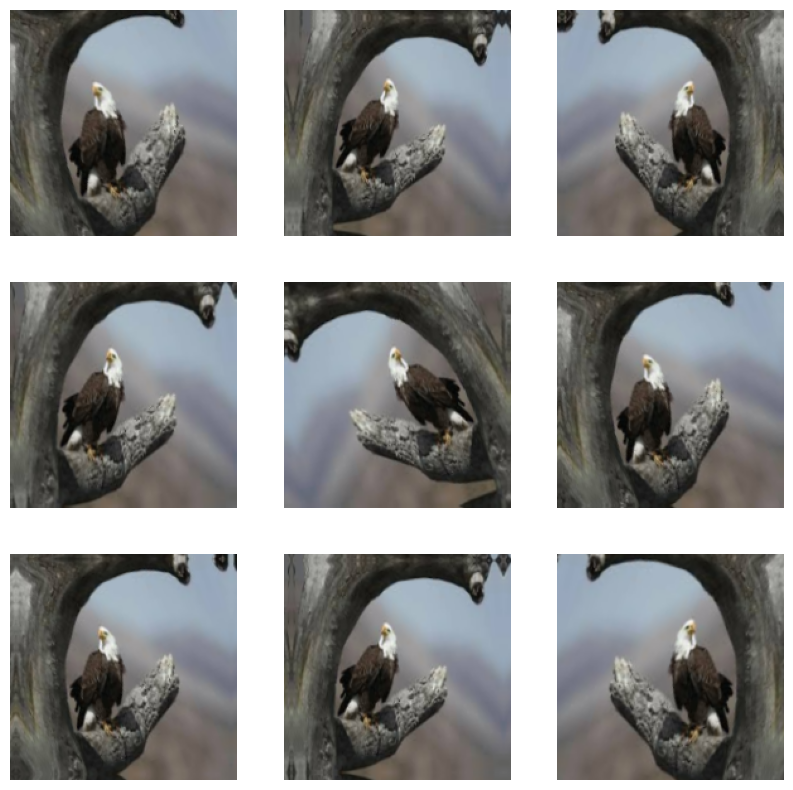

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Segundo Teste

Utilizando praticamente o mesmo modelo do primeiro teste, mas nesse, adicionamos nas camadas de treinamento, a função que aumenta o numero de imagens do nosso dataset, além de uma outra camada que realiza uma retirada aleatória(dropout), ou seja, um número de unidades de saída da camada durante o processo de treinamento, com intuito de melhorar a eficácia do treinamento.

In [21]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [24]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
135/135 [==============================] - 7s 30ms/step - loss: 4.4782 - accuracy: 0.0197 - val_loss: 4.4124 - val_accuracy: 0.0176
Epoch 2/15
135/135 [==============================] - 4s 28ms/step - loss: 4.3332 - accuracy: 0.0345 - val_loss: 4.4155 - val_accuracy: 0.0398
Epoch 3/15
135/135 [==============================] - 4s 29ms/step - loss: 4.1439 - accuracy: 0.0604 - val_loss: 4.1520 - val_accuracy: 0.0583
Epoch 4/15
135/135 [==============================] - 4s 29ms/step - loss: 3.9351 - accuracy: 0.0884 - val_loss: 4.1362 - val_accuracy: 0.0630
Epoch 5/15
135/135 [==============================] - 4s 27ms/step - loss: 3.7597 - accuracy: 0.1169 - val_loss: 3.8630 - val_accuracy: 0.1037
Epoch 6/15
135/135 [==============================] - 4s 29ms/step - loss: 3.5667 - accuracy: 0.1535 - val_loss: 3.6471 - val_accuracy: 0.1444
Epoch 7/15
135/135 [==============================] - 4s 33ms/step - loss: 3.4253 - accuracy: 0.1725 - val_loss: 3.8967 - val_accuracy: 0.1435

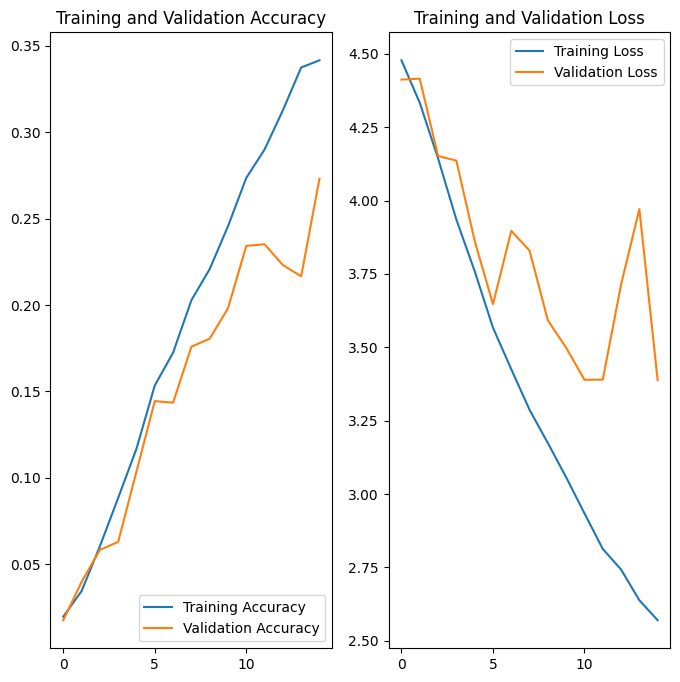

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Resultado do Teste 2

Por algum motivo que não consegui identificar, o resultado desse treinamento mesmo com as melhorias acabou ficando pior no conjunto de treinamento e teve uma manutenção de eficacia no de teste, com cerca de 30% de acuracia.

# Terceiro Teste

Utilizando os mesmo parametros, porem com um numero de epochs maior.

In [26]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

model.save('modelo_30epochs.h5')

Epoch 1/30
135/135 [==============================] - 4s 31ms/step - loss: 2.4650 - accuracy: 0.3646 - val_loss: 3.5118 - val_accuracy: 0.2741
Epoch 2/30
135/135 [==============================] - 4s 30ms/step - loss: 2.3935 - accuracy: 0.3887 - val_loss: 3.6674 - val_accuracy: 0.2704
Epoch 3/30
135/135 [==============================] - 4s 29ms/step - loss: 2.3024 - accuracy: 0.4012 - val_loss: 3.6637 - val_accuracy: 0.2731
Epoch 4/30
135/135 [==============================] - 4s 29ms/step - loss: 2.2380 - accuracy: 0.4236 - val_loss: 3.2351 - val_accuracy: 0.3083
Epoch 5/30
135/135 [==============================] - 4s 30ms/step - loss: 2.1672 - accuracy: 0.4340 - val_loss: 3.3253 - val_accuracy: 0.3176
Epoch 6/30
135/135 [==============================] - 4s 31ms/step - loss: 2.1065 - accuracy: 0.4458 - val_loss: 3.4919 - val_accuracy: 0.3287
Epoch 7/30
135/135 [==============================] - 4s 29ms/step - loss: 2.0450 - accuracy: 0.4604 - val_loss: 3.6452 - val_accuracy: 0.3157

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


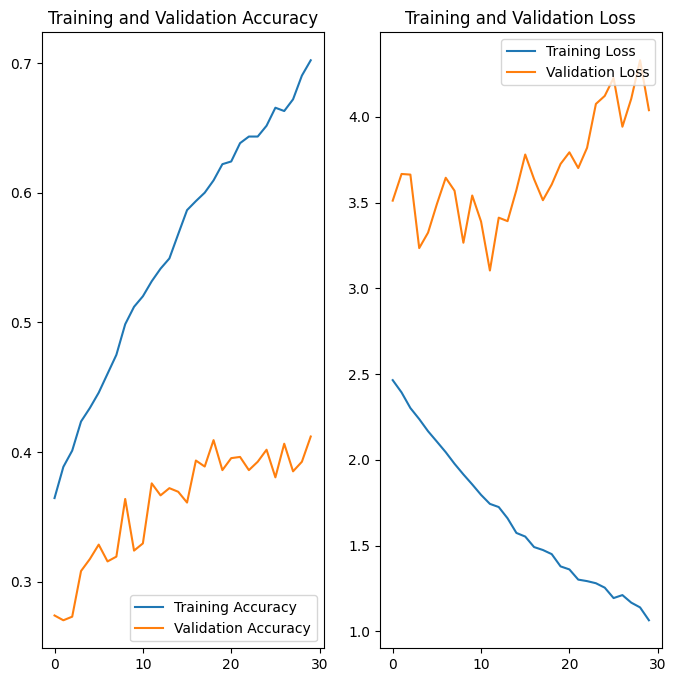

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Quarto Teste

Nesse ultimo teste, eu tentei uma nova abordagem, tinha feito algumas melhorias, mas não estava obtendo resultados bons,nem razóaveis, então após algumas pesquisas, vi que utilizar um modelo já treinado anteriormente, poderia ajudar resolver esse problema.

In [31]:
from tensorflow.keras.applications import MobileNetV2
num_classes = len(class_names)


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False



model = Sequential([
  data_augmentation,
    layers.Rescaling(1./255),

    # Substitua as camadas convolucionais pelo modelo pré-treinado
    base_model,

    layers.GlobalAveragePooling2D(),

    # Adicione camadas densas adicionais conforme necessário
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_classes)

])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


epochs=20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

model.save('modelo_final.keras')

Epoch 1/20
135/135 [==============================] - 10s 48ms/step - loss: 3.4333 - accuracy: 0.2530 - val_loss: 1.7128 - val_accuracy: 0.6454
Epoch 2/20
135/135 [==============================] - 6s 41ms/step - loss: 1.8845 - accuracy: 0.5618 - val_loss: 1.0807 - val_accuracy: 0.7741
Epoch 3/20
135/135 [==============================] - 6s 41ms/step - loss: 1.4290 - accuracy: 0.6484 - val_loss: 0.8596 - val_accuracy: 0.8019
Epoch 4/20
135/135 [==============================] - 6s 41ms/step - loss: 1.1608 - accuracy: 0.7035 - val_loss: 0.7908 - val_accuracy: 0.8157
Epoch 5/20
135/135 [==============================] - 5s 38ms/step - loss: 1.0333 - accuracy: 0.7382 - val_loss: 0.7149 - val_accuracy: 0.8259
Epoch 6/20
135/135 [==============================] - 6s 42ms/step - loss: 0.9237 - accuracy: 0.7604 - val_loss: 0.6675 - val_accuracy: 0.8278
Epoch 7/20
135/135 [==============================] - 5s 39ms/step - loss: 0.8290 - accuracy: 0.7812 - val_loss: 0.6114 - val_accuracy: 0.838

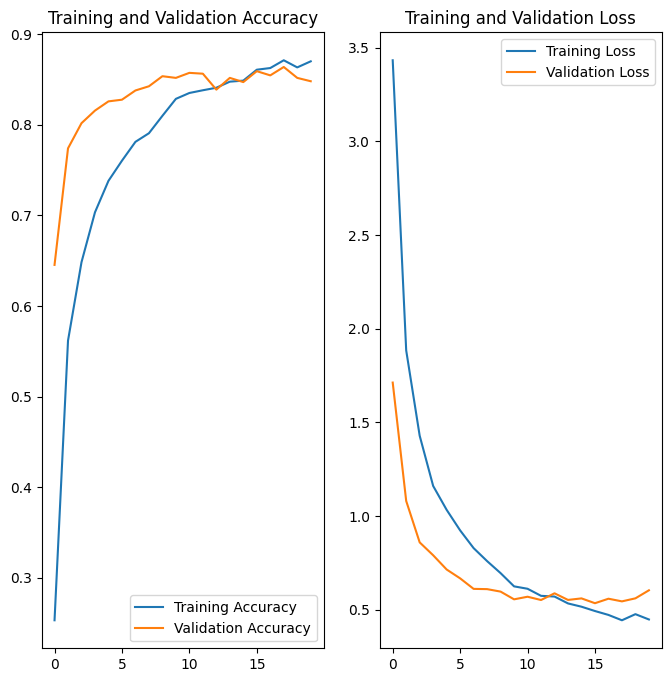

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
model = tf.keras.models.load_model("/content/drive/MyDrive/projeto-cocada/dataset/modelo_final.keras")

results = model.evaluate(val_ds, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.60383
Test Accuracy: 84.81%


In [35]:
tf.keras.backend.clear_session()

caminho_modelo_salvo = '/content/drive/MyDrive/projeto-cocada/dataset/modelo_final.keras'

# Carregar o modelo salvo
model = tf.keras.models.load_model(caminho_modelo_salvo)

# Caminho local para a imagem
caminho_imagem_local = '/content/drive/MyDrive/projeto-cocada/teste/cobra.jpg'  # Substitua pelo caminho real da sua imagem local

img = tf.keras.utils.load_img(
    caminho_imagem_local, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)

score = tf.nn.softmax(predictions[0])


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 2s 2s/step
This image most likely belongs to gorilla with a 53.84 percent confidence.


In [37]:
tf.keras.backend.clear_session()

caminho_modelo_salvo = '/content/drive/MyDrive/projeto-cocada/dataset/modelo_final.keras'

# Carregar o modelo salvo
model = tf.keras.models.load_model(caminho_modelo_salvo)

# Caminho local para a imagem
caminho_imagem_local = '/content/drive/MyDrive/projeto-cocada/teste/elefa.jpg'  # Substitua pelo caminho real da sua imagem local

img = tf.keras.utils.load_img(
    caminho_imagem_local, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

predictions = model.predict(img_array)

score = tf.nn.softmax(predictions[0])


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 1s 1s/step
This image most likely belongs to elephant with a 96.38 percent confidence.


In [40]:
import os

# Caminho para o diretório de imagens de teste
caminho_diretorio_teste = '/content/drive/MyDrive/projeto-cocada/teste'

# Lista todas as imagens no diretório
imagens_teste = [f for f in os.listdir(caminho_diretorio_teste) if os.path.isfile(os.path.join(caminho_diretorio_teste, f))]

# Loop sobre cada imagem
for imagem_nome in imagens_teste:
    # Caminho completo para a imagem
    caminho_imagem_local = os.path.join(caminho_diretorio_teste, imagem_nome)

    # Carrega a imagem
    img = tf.keras.utils.load_img(
        caminho_imagem_local, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Cria um lote (batch)

    # Faz a previsão
    predictions = model.predict(img_array)

    # Obtém as probabilidades
    score = tf.nn.softmax(predictions[0])

    # Exibe os resultados
    print("Nome da Imagem: ",imagem_nome)
    print("Para a imagem {}: Pertence a {} com {:.2f}% de confiança."
          .format(imagem_nome, class_names[np.argmax(score)], 100 * np.max(score)))
    print('\n')


1/1 [==============================] - 0s 22ms/step
Nome da Imagem:  cao4.webp
Para a imagem cao4.webp: Pertence a dog com 99.93% de confiança.


1/1 [==============================] - 0s 20ms/step
Nome da Imagem:  rato.jpg
Para a imagem rato.jpg: Pertence a hamster com 98.39% de confiança.


1/1 [==============================] - 0s 21ms/step
Nome da Imagem:  papa.jpeg
Para a imagem papa.jpeg: Pertence a parrot com 100.00% de confiança.


1/1 [==============================] - 0s 21ms/step
Nome da Imagem:  cao1.jpg
Para a imagem cao1.jpg: Pertence a bee com 53.61% de confiança.


1/1 [==============================] - 0s 24ms/step
Nome da Imagem:  cao3.jpg
Para a imagem cao3.jpg: Pertence a ox com 73.61% de confiança.


1/1 [==============================] - 0s 21ms/step
Nome da Imagem:  rapo.jpg
Para a imagem rapo.jpg: Pertence a fox com 97.55% de confiança.


1/1 [==============================] - 0s 20ms/step
Nome da Imagem:  cobra.jpg
Para a imagem cobra.jpg: Pertence a gorilla co